In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
plt.rcParams['figure.dpi'] = 400

sns.set_theme(style='whitegrid',rc={'axes.facecolor':'#EFEAE4', 'figure.facecolor':'#EFEAE4'})

In [5]:
data = pd.read_csv('datasets/heart.csv')

data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

### Dataset Overview

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:

features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Convert categorical features to object type
feat_convert = [feat for feat in data.columns if feat not in features]

data[feat_convert] = data[feat_convert].astype('object')

data.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [8]:
data.describe().T

count        mean        std    min    25%    50%    75%    max
age       303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   77.0
trestbps  303.0  131.623762  17.538143   94.0  120.0  130.0  140.0  200.0
chol      303.0  246.264026  51.830751  126.0  211.0  240.0  274.5  564.0
thalach   303.0  149.646865  22.905161   71.0  133.5  153.0  166.0  202.0
oldpeak   303.0    1.039604   1.161075    0.0    0.0    0.8    1.6    6.2

In [9]:
data.describe(include='object')

sex   cp  fbs  restecg  exang  slope   ca  thal  target
count   303  303  303      303    303    303  303   303     303
unique    2    4    2        3      2      3    5     4       2
top       1    0    0        1      0      2    0     2       1
freq    207  143  258      152    204    142  175   166     165

### EDA

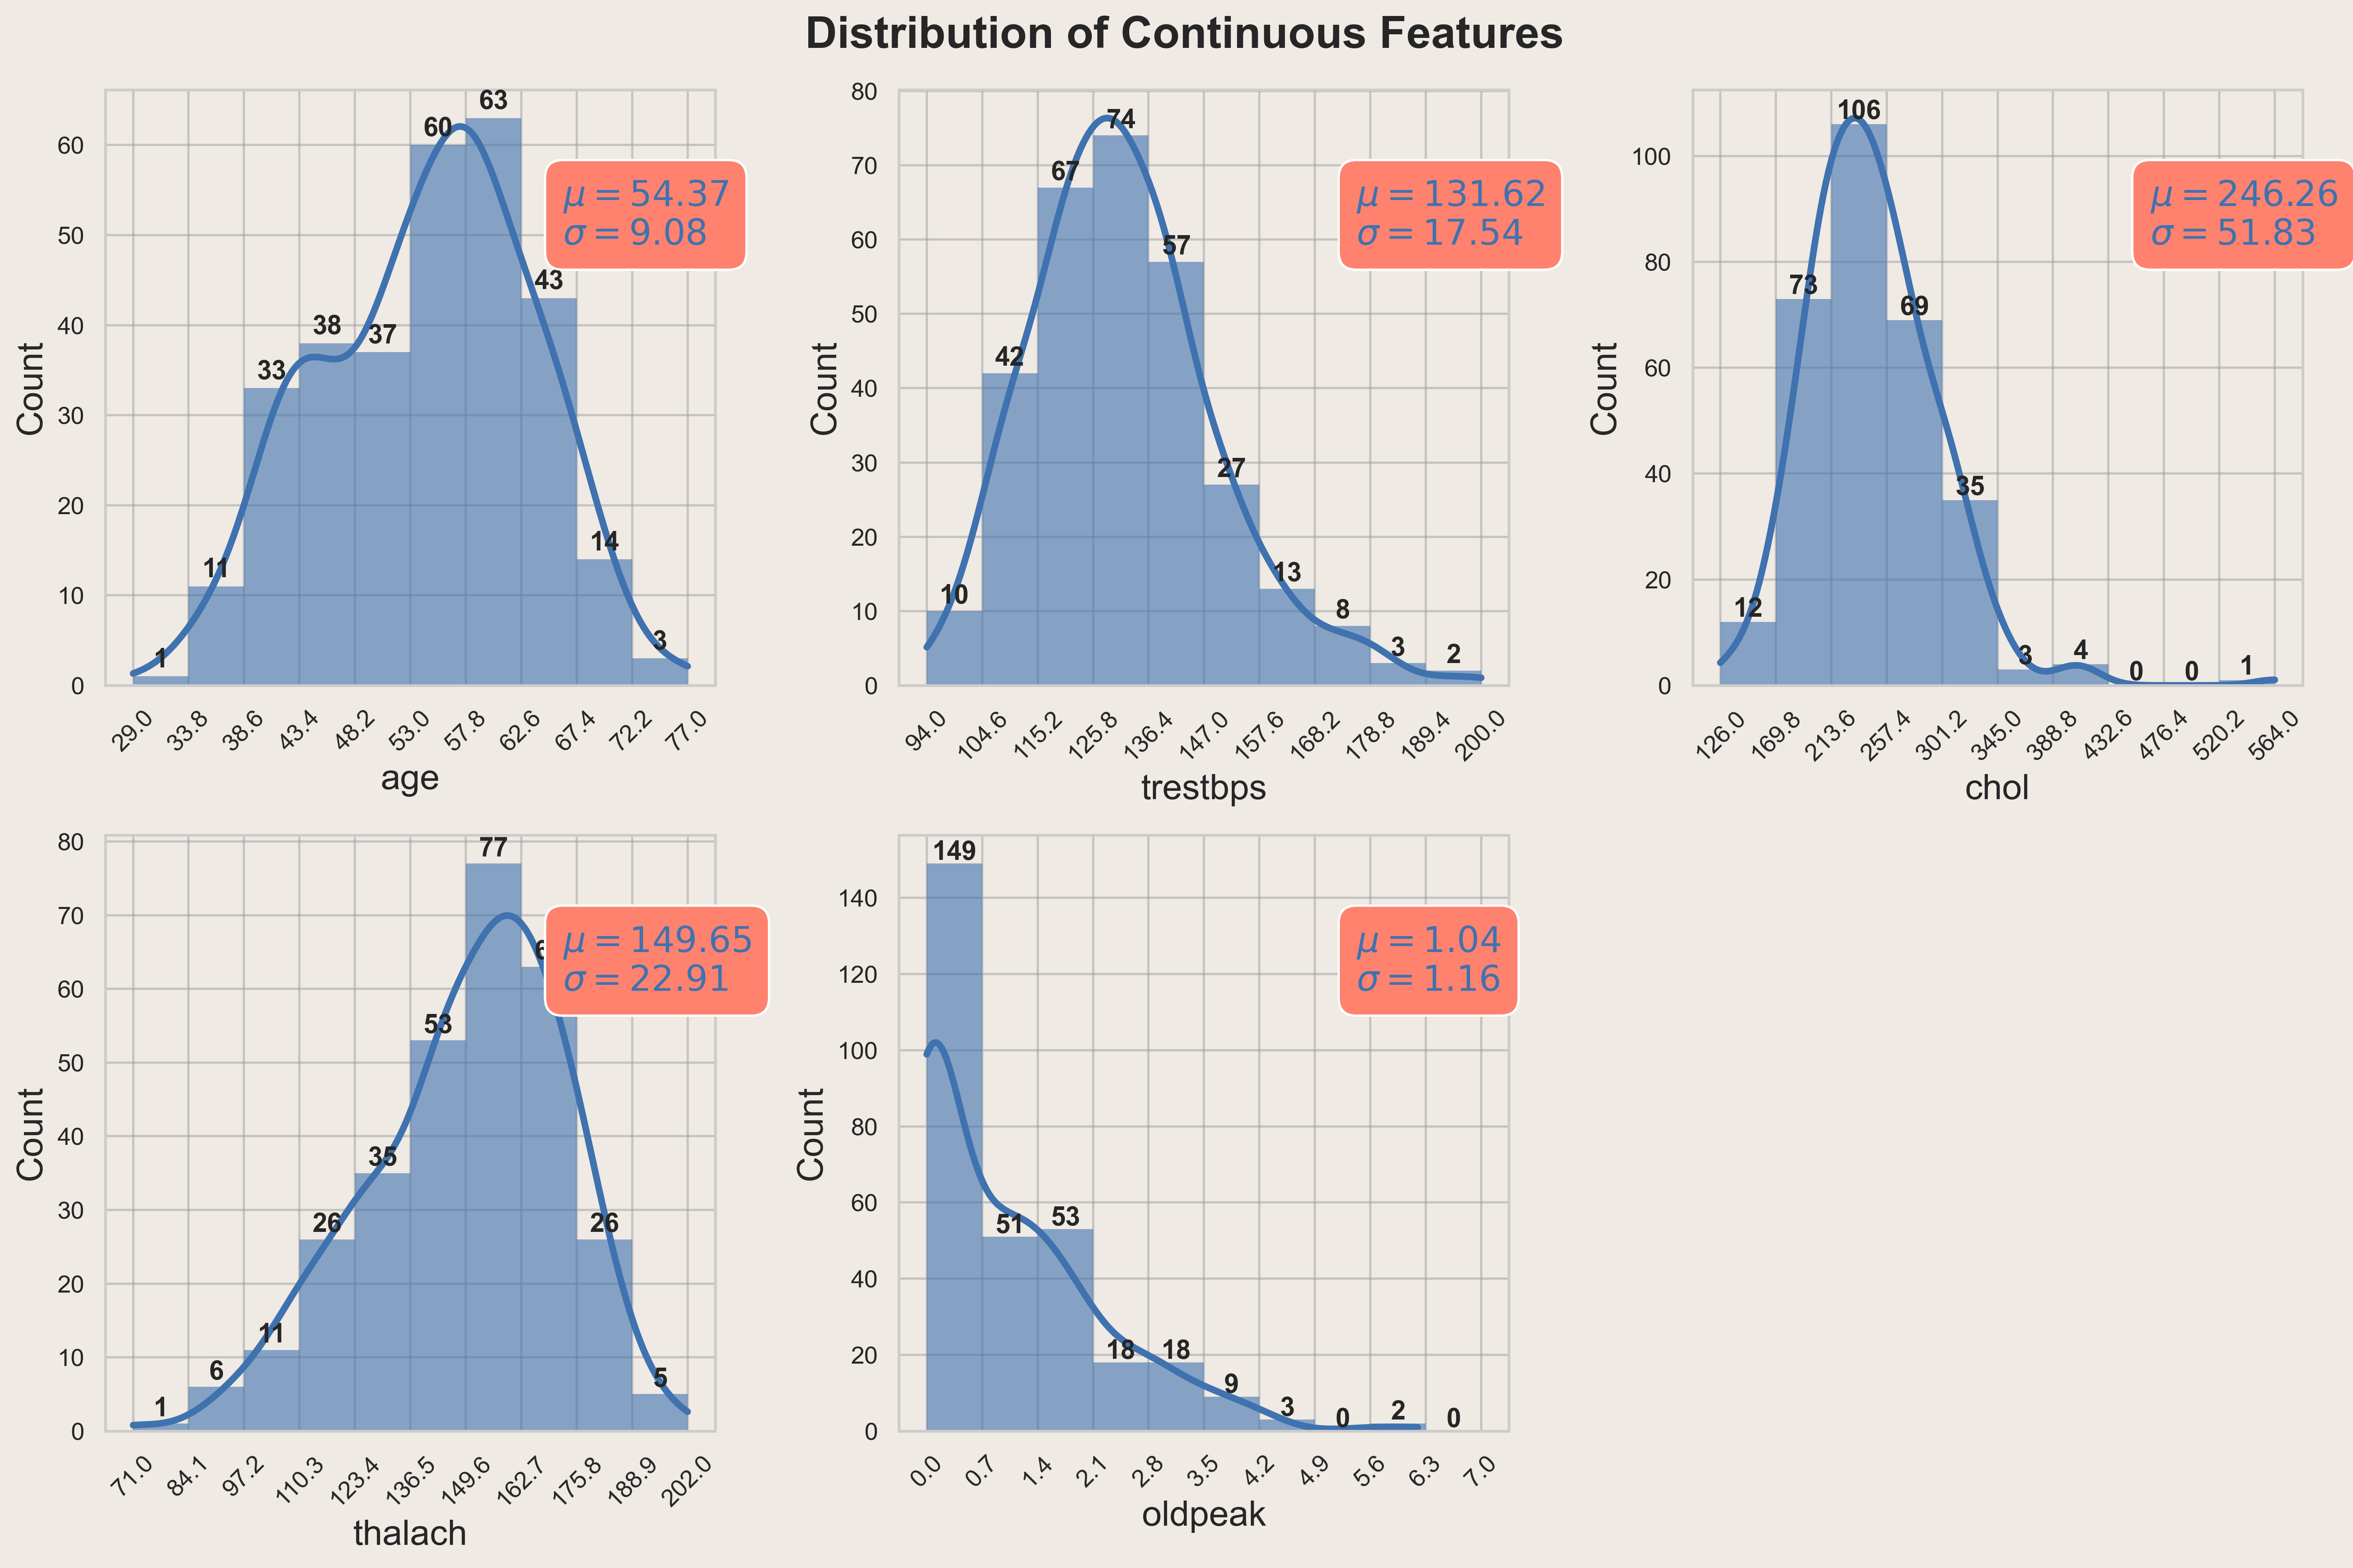

In [10]:
data_continuous = data[features]

# subplot
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))

for i, col in enumerate(data_continuous.columns):
	x = i // 3
	y = i % 3
	values, bins = np.histogram(data_continuous[col], range=(np.floor(data_continuous[col].min()), np.ceil(data_continuous[col].max())))
	graph = sns.histplot(data=data_continuous,x=col,bins=bins,kde=True,ax=axes[x,y],edgecolor='none',color='#3F72AF',alpha=0.6,line_kws={'lw':3})
	axes[x,y].set_xlabel(col,fontsize=16)
	axes[x,y].set_ylabel('Count',fontsize=16)
	axes[x,y].set_xticks(np.round(bins,1))
	axes[x,y].set_xticklabels(axes[x,y].get_xticks(),rotation=45)
	axes[x,y].grid(color='#9D9D9D',alpha=0.5)
	for j, p in enumerate(graph.patches):
		axes[x,y].annotate('{}'.format(p.get_height()),(p.get_x() + p.get_width() / 2, p.get_height() + 1), ha='center', fontsize=12, fontweight='bold')
		text = '\n'.join((
			r'$\mu=%.2f$' % data_continuous[col].mean(),
			r'$\sigma=%.2f$' % data_continuous[col].std()
		))
		axes[x,y].text(0.75, 0.85, text, transform=axes[x,y].transAxes,  verticalalignment='top', fontsize=16,color='#3F72AF', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

axes[1,2].axis('off')
plt.suptitle('Distribution of Continuous Features',fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()



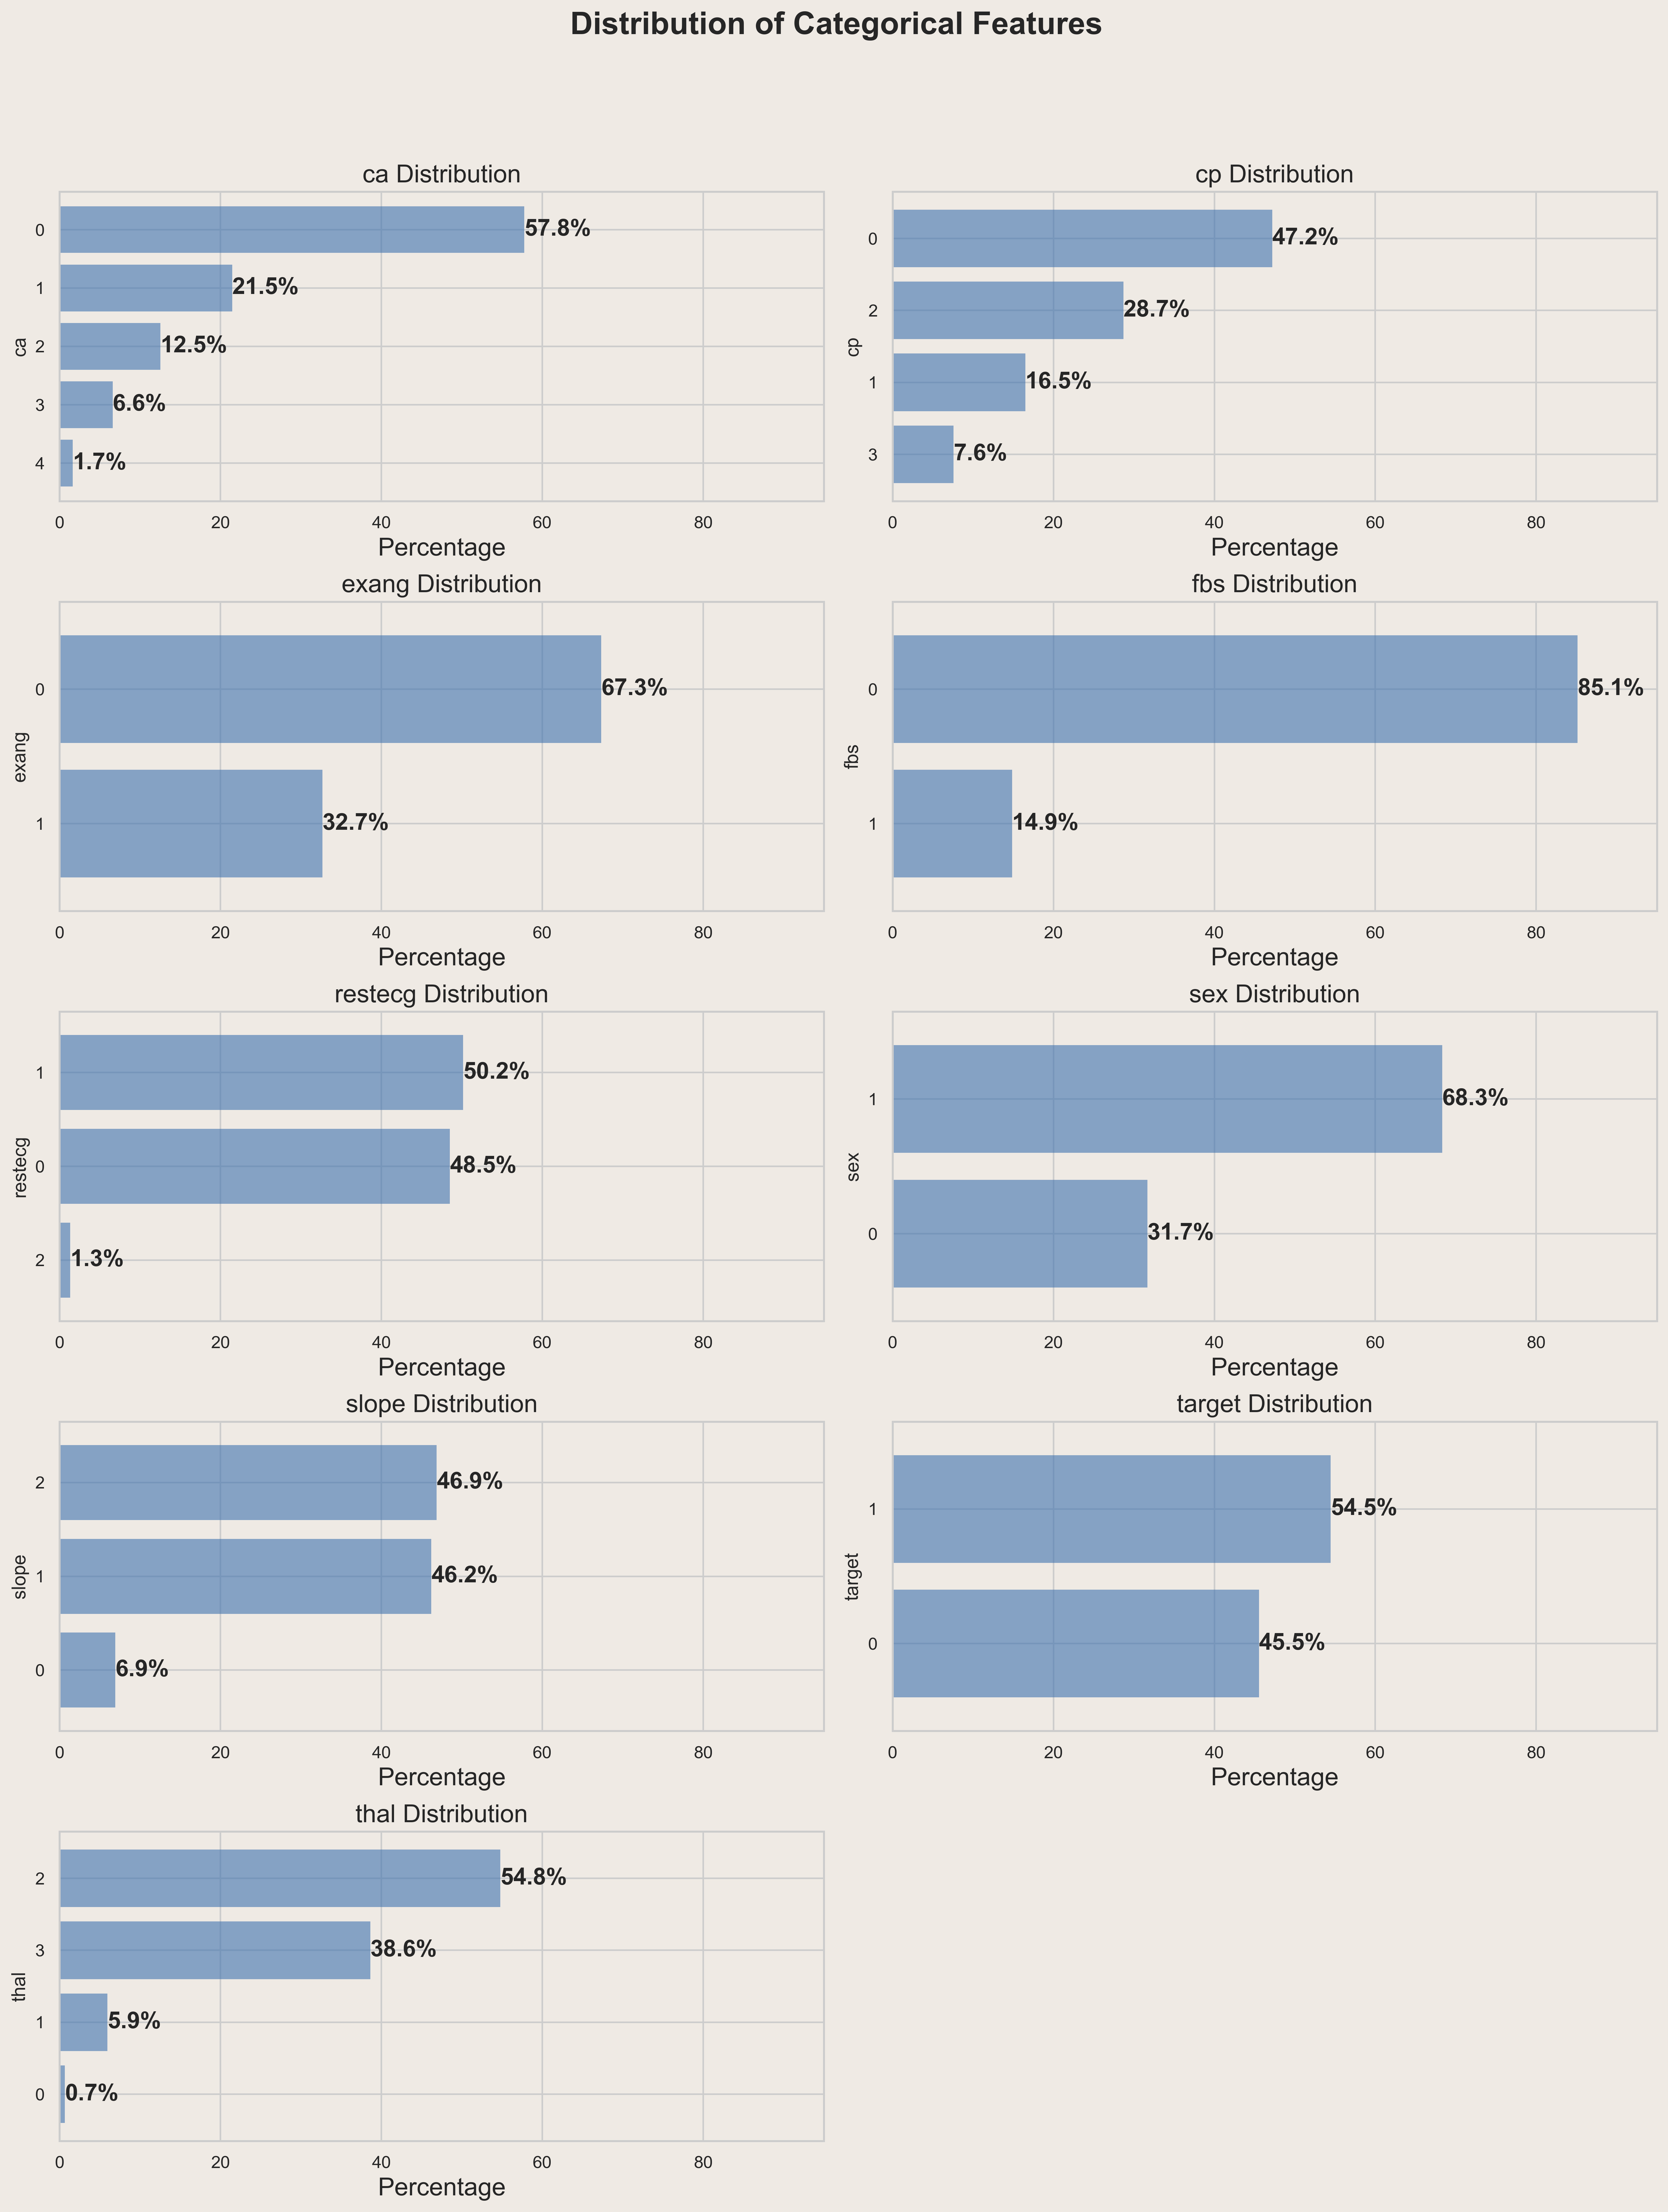

In [11]:
features1 = data.columns.difference(features)
data_categorical = data[features1]

# subplot
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(15,20))

for i, col in enumerate(features1):
	row = i // 2
	col_index = i % 2

	val_counts = data[col].value_counts(normalize=True).mul(100).sort_values()

	val_counts.plot(kind='barh', ax=axes[row, col_index], width=0.8, color='#3F72AF', alpha=0.6, edgecolor='none')

	for index, value in enumerate(val_counts):
		axes[row,col_index].text(value,index,str(round(value,1)) + '%', fontsize=15,weight='bold',va='center')
	
	axes[row,col_index].set_xlim([0,95])
	axes[row,col_index].set_xlabel('Percentage',fontsize=16)
	axes[row,col_index].set_title(f'{col} Distribution',fontsize=16)

axes[4,1].axis('off')
plt.suptitle('Distribution of Categorical Features',fontsize=20,fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


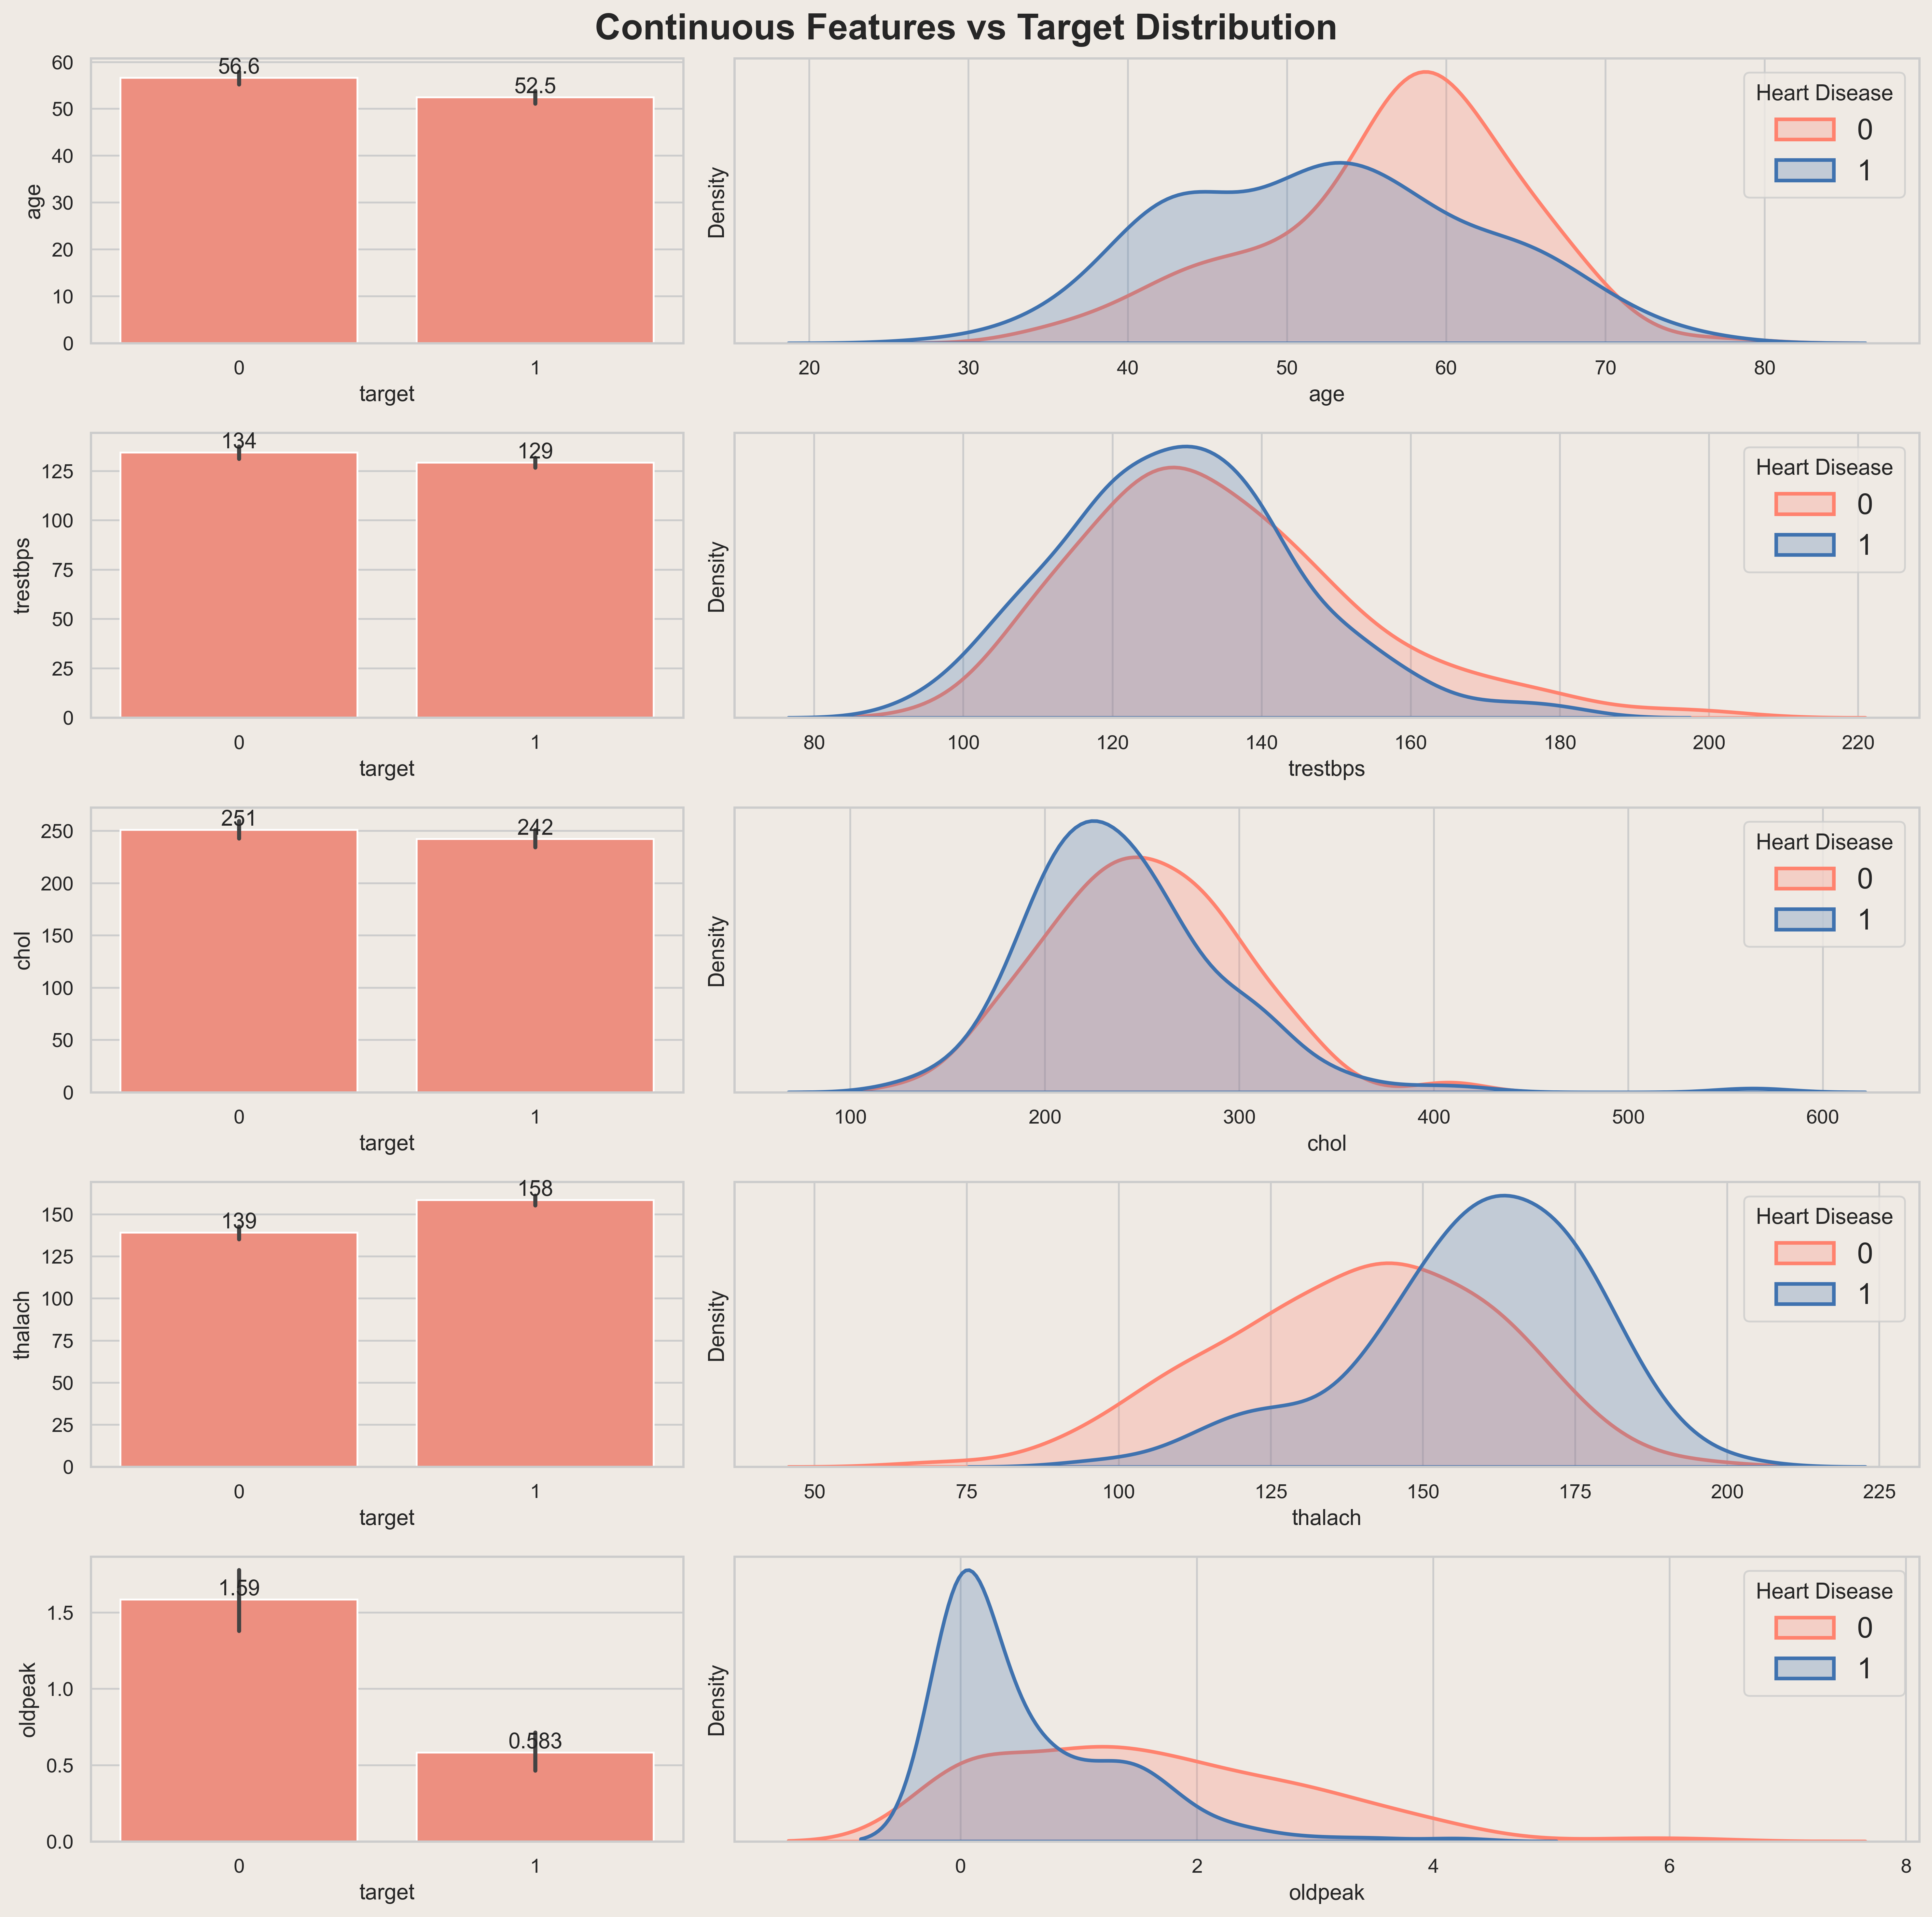

In [12]:
sns.set_palette(['#ff826e','#3F72AF'])

fig, axes = plt.subplots(len(features), 2, figsize=(15, 15), gridspec_kw={'width_ratios':[1,2]})

for i, col in enumerate(features):
	graph = sns.barplot(data=data, x='target', y=col, ax=axes[i,0])

	sns.kdeplot(data=data[data['target']==0],x=col,fill=True,linewidth=2,ax=axes[i,1],label='0')
	sns.kdeplot(data=data[data['target']==1],x=col,fill=True, linewidth=2, ax=axes[i,1],label='1')
	axes[i,1].set_yticks([])
	axes[i,1].legend(title='Heart Disease',fontsize=16, loc='upper right')

	for con in graph.containers:
		graph.bar_label(con,fmt='%.3g')
plt.suptitle('Continuous Features vs Target Distribution',fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
features2 = [feature for feature in features1 if feature != 'target']

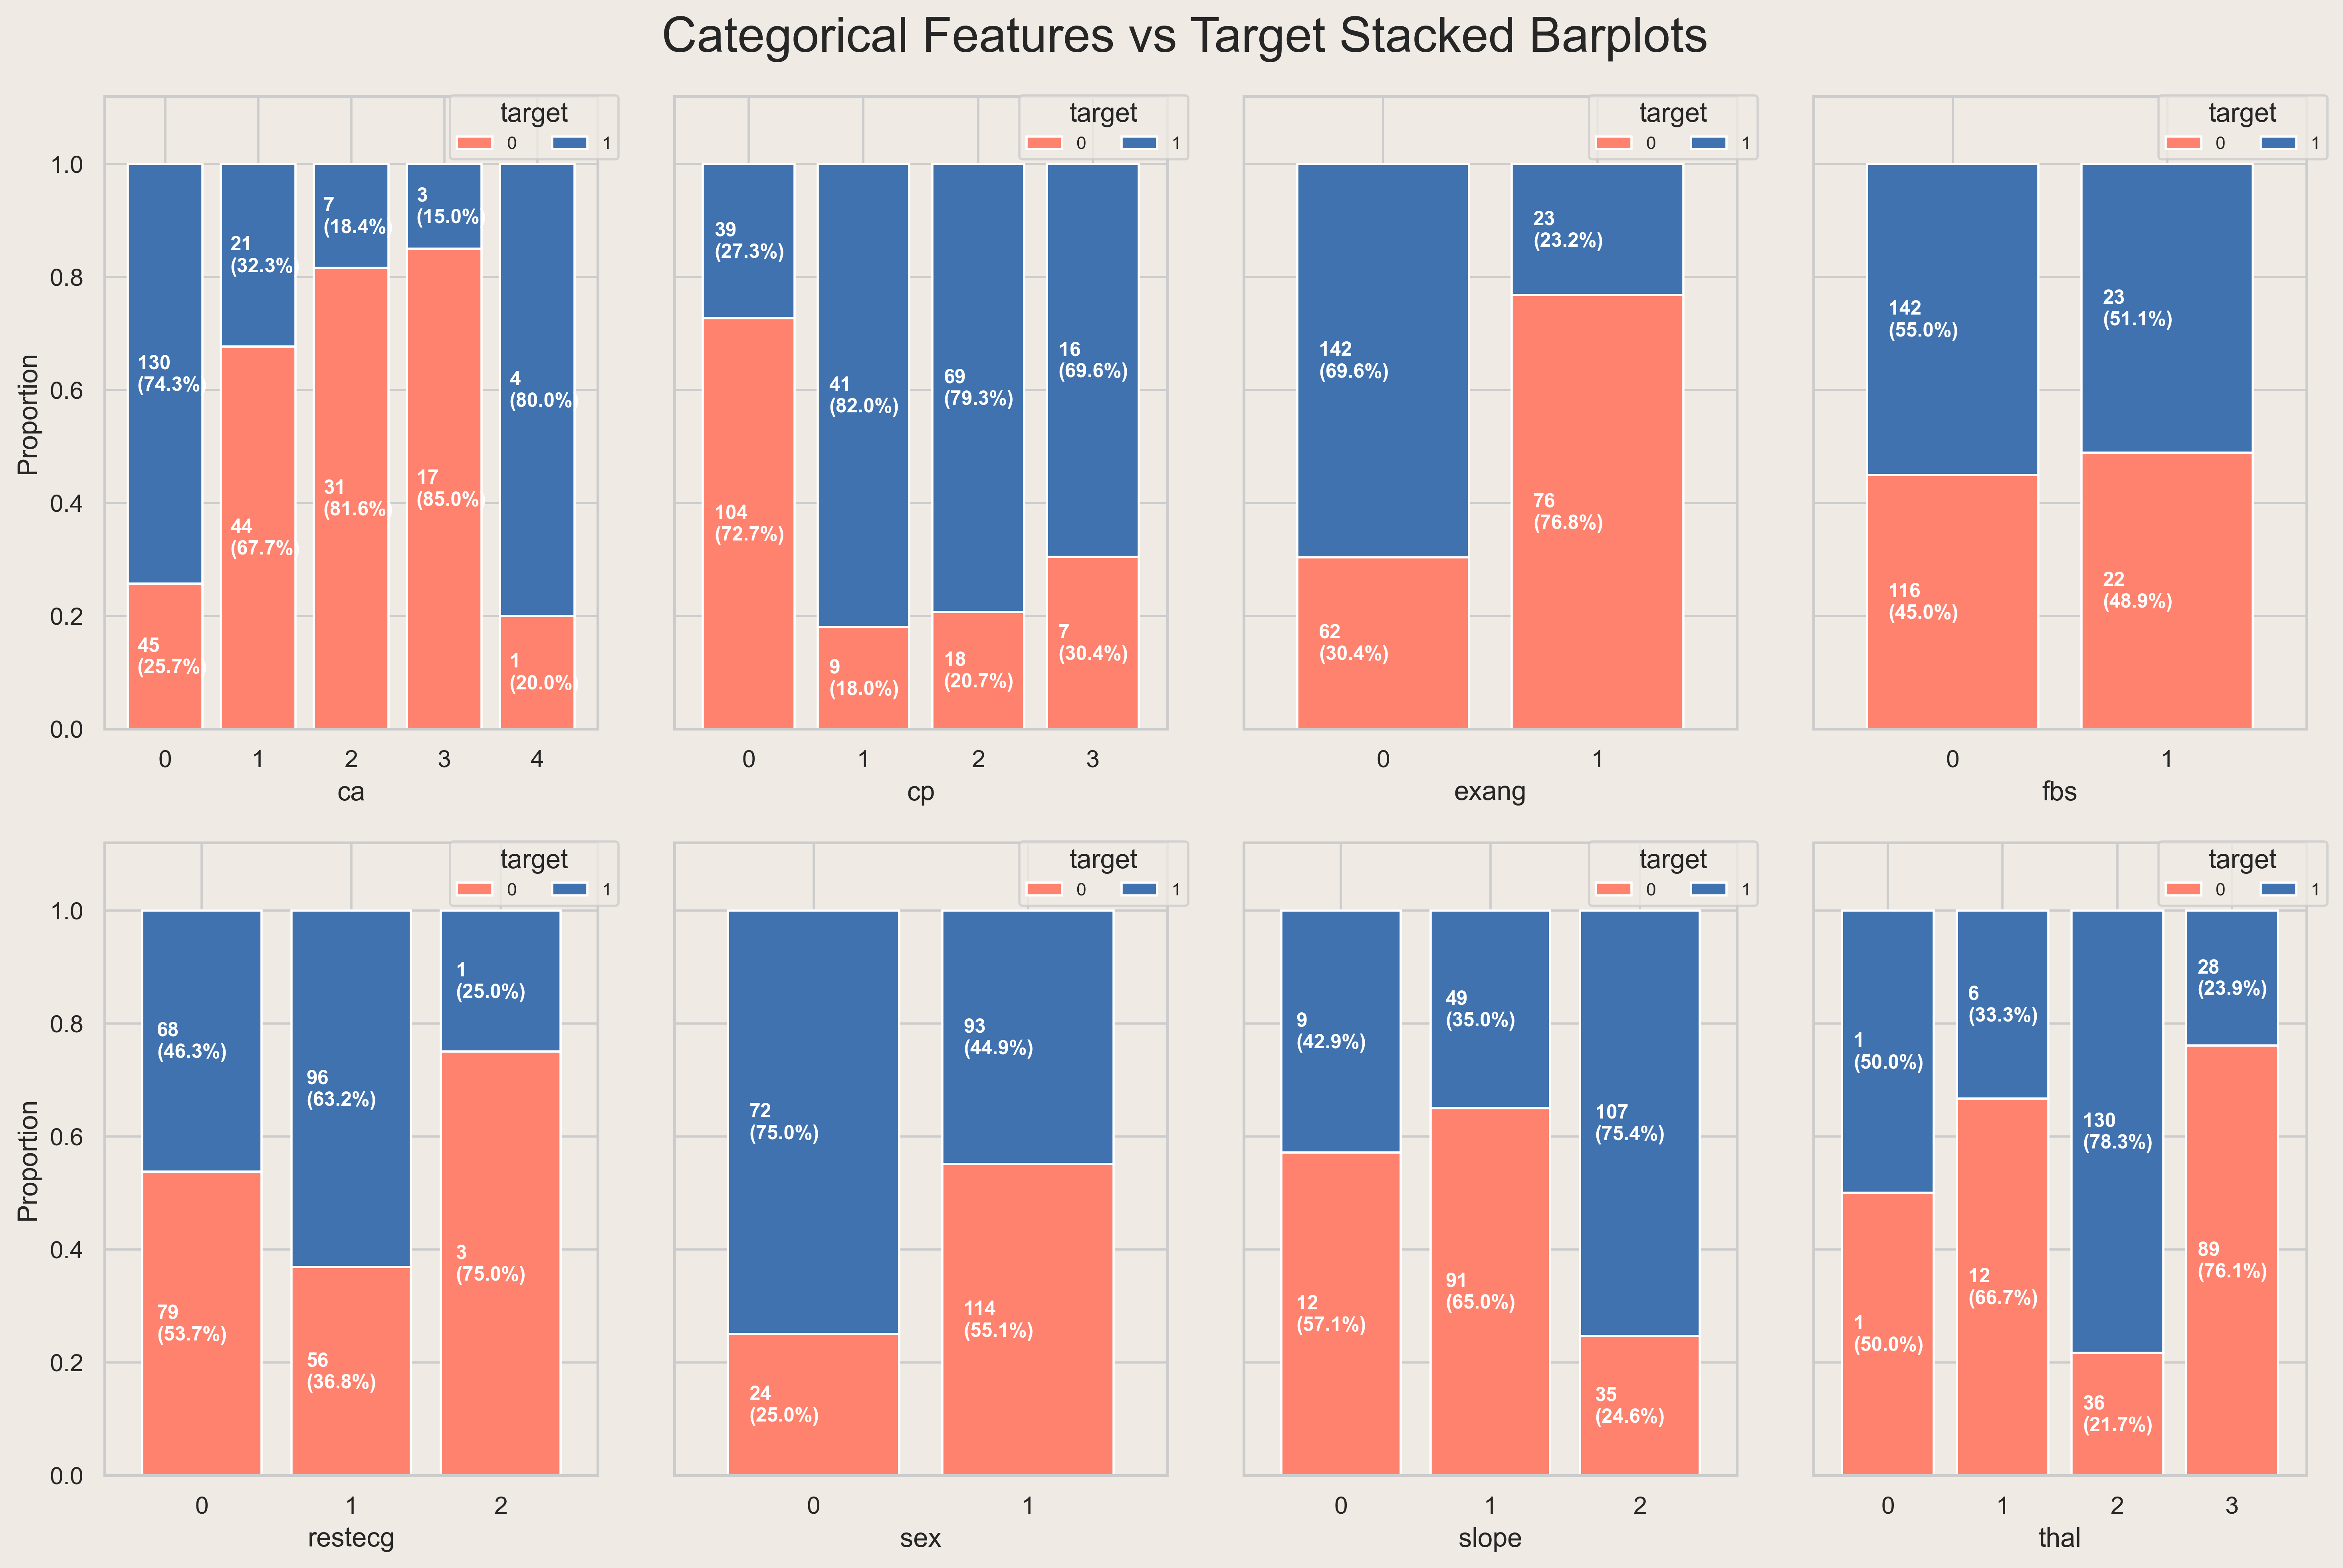

In [14]:


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(features2):
    
    cross_tab = pd.crosstab(index=data[col], columns=data['target'])
    

    cross_tab_prop = pd.crosstab(index=data[col], columns=data['target'], normalize='index')

    cmp = ListedColormap(['#ff826e', '#3F72AF'])

    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=axes[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
   
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            axes[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'{count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "white", fontsize=9, fontweight="bold")
    

    axes[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)

    axes[x,y].set_ylim([0,1.12])

    axes[x,y].set_xticklabels(axes[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

### Data Processing

In [15]:
data.isnull().sum().sum()

0

In [16]:
features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [17]:
Q1 = data[features].quantile(0.25)
Q3 = data[features].quantile(0.75)
IQR = Q3- Q1
outliers_count_specified = ((data[features] < (Q1 - 1.5 * IQR)) | (data[features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

In [18]:
encoded = pd.get_dummies(data,columns=['cp','restecg','thal'],drop_first=True)

feat_to_convert = ['sex','fbs','exang','slope','ca','target'
		   ,'cp_1' ,'cp_2','cp_3','restecg_1','restecg_2','thal_1','thal_2','thal_3']

for feat in feat_to_convert:
	encoded[feat] = encoded[feat].astype(int)

encoded.dtypes

age            int64
sex            int64
trestbps       int64
chol           int64
fbs            int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
target         int64
cp_1           int64
cp_2           int64
cp_3           int64
restecg_1      int64
restecg_2      int64
thal_1         int64
thal_2         int64
thal_3         int64
dtype: object

In [19]:
encoded.head()

age  sex  trestbps  chol  fbs  thalach  exang  oldpeak  slope  ca  target  \
0   63    1       145   233    1      150      0      2.3      0   0       1   
1   37    1       130   250    0      187      0      3.5      0   0       1   
2   41    0       130   204    0      172      0      1.4      2   0       1   
3   56    1       120   236    0      178      0      0.8      2   0       1   
4   57    0       120   354    0      163      1      0.6      2   0       1   

   cp_1  cp_2  cp_3  restecg_1  restecg_2  thal_1  thal_2  thal_3  
0     0     0     1          0          0       1       0       0  
1     0     1     0          1          0       0       1       0  
2     1     0     0          0          0       0       1       0  
3     1     0     0          1          0       0       1       0  
4     0     0     0          1          0       0       1       0

In [20]:
X = encoded.drop('target', axis=1)
Y = encoded['target']

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [22]:
features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [23]:
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

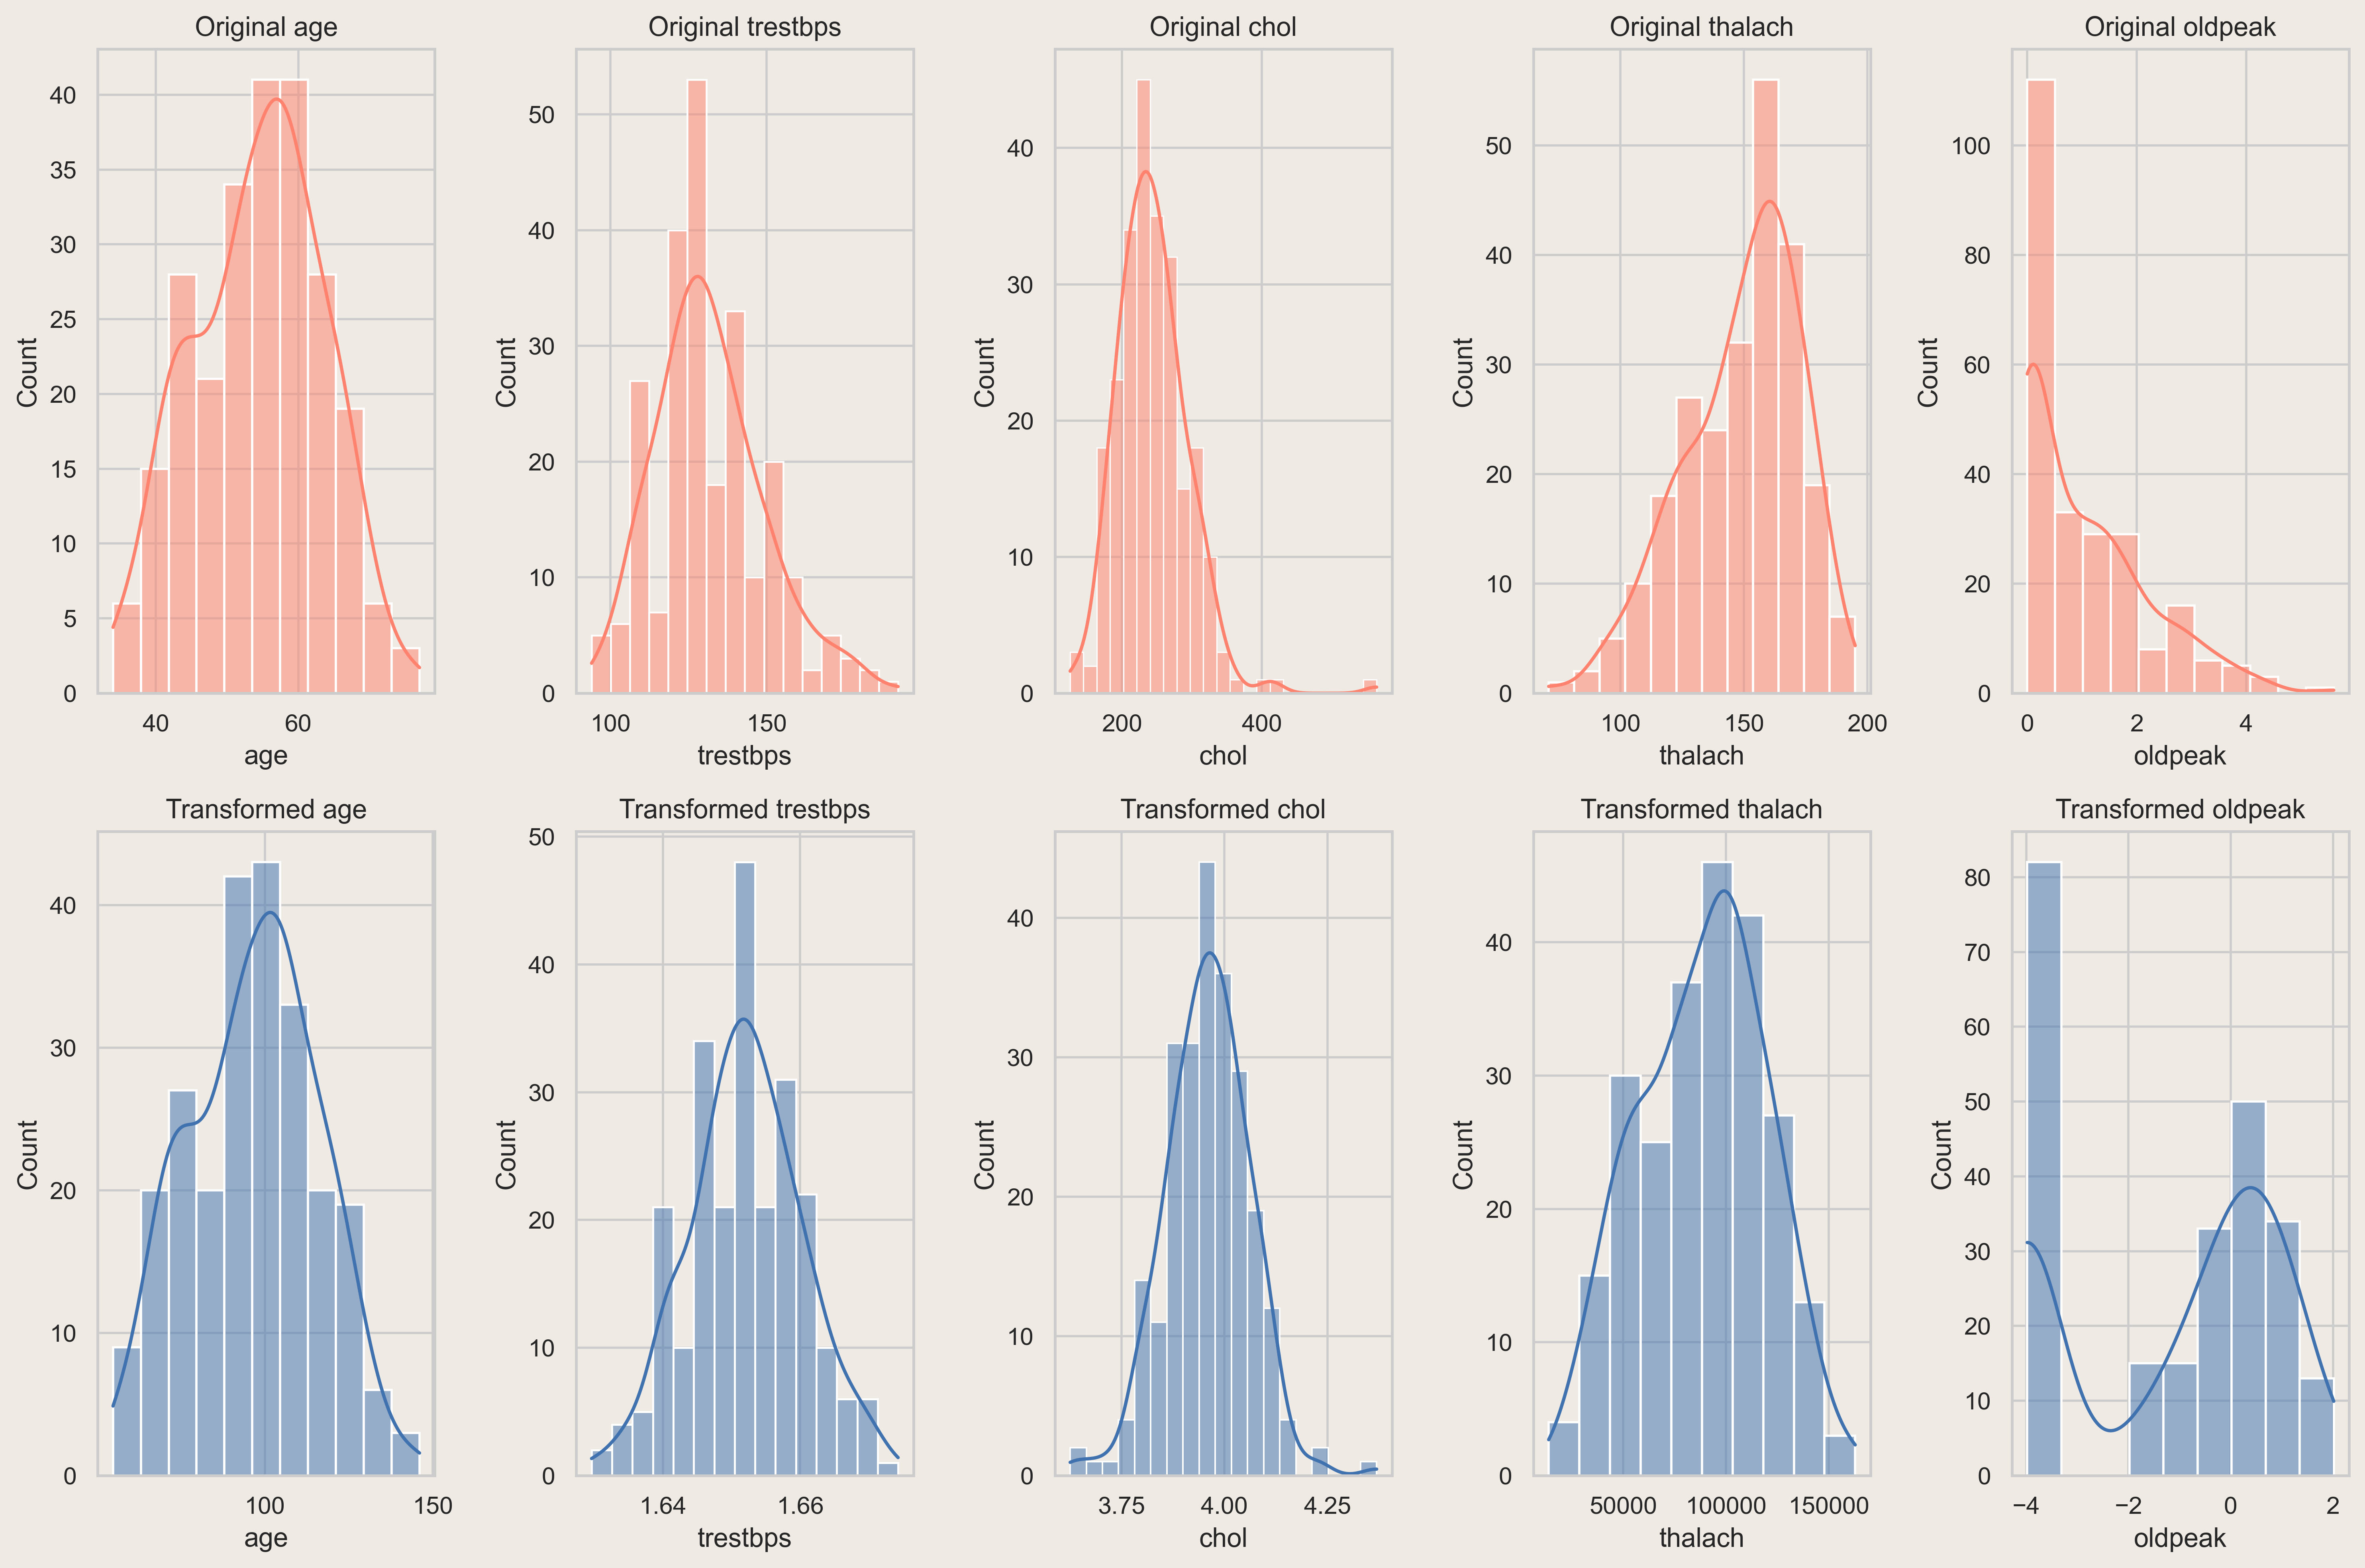

In [24]:
fig, axes = plt.subplots(2,5,figsize=(15,10))

for i, col in enumerate(features):
	sns.histplot(X_train[col],kde=True, ax=axes[0,i], color='#ff826e').set_title(f'Original {col}')

lambdas = {}

for i, col in enumerate(features):
	if X_train[col].min() > 0:
		X_train[col],lambdas[col] = boxcox(X_train[col])
		X_test[col] = boxcox(X_test[col],lmbda=lambdas[col])
		sns.histplot(X_train[col], kde=True, ax=axes[1,i],color='#3F72AF').set_title(f'Transformed {col}')
	else:
		sns.histplot(X_train[col],kde=True,ax=axes[1,i],color='red').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

In [25]:
X_train.head()

age  sex  trestbps      chol  fbs       thalach  exang   oldpeak  \
269   99.775363    1  1.652121  4.044511    1  34193.227632      1  0.490856   
191  104.060287    1  1.651135  3.909224    0  61564.640490      1  0.846853   
15    87.096593    0  1.646936  3.916243    0  97354.894861      0  0.490856   
224   95.519188    1  1.641027  3.960431    0  55975.891019      1  1.130195   
250   89.190732    1  1.656715  4.069855    0  51729.486474      1  1.634849   

     slope  ca  cp_1  cp_2  cp_3  restecg_1  restecg_2  thal_1  thal_2  thal_3  
269      0   0     0     0     0          0          0       0       0       1  
191      1   3     0     0     0          0          0       0       0       1  
15       1   0     0     1     0          1          0       0       1       0  
224      1   1     0     0     0          1          0       0       0       1  
250      1   3     0     0     0          1          0       0       0       1

### Decision Tree Model

In [26]:
dt_base = DecisionTreeClassifier(random_state=0)

In [27]:
def tune_hyperparameters(clf, param_grid, X_train, Y_train, scoring='recall', n_splits=3):
	cv = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=0)

	clf_grid = GridSearchCV(clf,param_grid,cv=cv, scoring=scoring,n_jobs=-1)

	clf_grid.fit(X_train,Y_train)

	best_hyperparameters = clf_grid.best_params_

	return clf_grid.best_estimator_, best_hyperparameters

In [28]:
dt_param_grid={
	'criterion': ['gini', 'entropy'],
    	'max_depth': [2,3],
    	'min_samples_split': [2, 3, 4],
    	'min_samples_leaf': [1, 2]
}

In [29]:
best_dt, best_dt_hyperparams = tune_hyperparameters(dt_base,dt_param_grid,X_train,Y_train)

In [30]:
print('Optimaled DT: \n',best_dt_hyperparams)

Optimaled DT: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [31]:
print(classification_report(Y_train,best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [32]:
print(classification_report(Y_test,best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [33]:
def evaluate_model(model, X_test, Y_test, model_name):
	Y_pred = model.predict(X_test)

	report = classification_report(Y_test,Y_pred,output_dict=True)

	metrics = {
		"precision_0": report["0"]["precision"],
		"precision_1": report["1"]["precision"],
		"recall_0": report["0"]["recall"],
		"recall_1": report["1"]["recall"],
		"f1_0": report["0"]["f1-score"],
		"f1_1": report["1"]["f1-score"],
		"macro_avg_precision": report["macro avg"]["precision"],
		"macro_avg_recall": report["macro avg"]["recall"],
		"macro_avg_f1": report["macro avg"]["f1-score"],
		"accuracy": accuracy_score(Y_test, Y_pred)
	}

	data = pd.DataFrame(metrics,index=[model_name]).round(2)
	return data

In [34]:
dt_evaluation = evaluate_model(best_dt,X_test,Y_test,'DT')
dt_evaluation

precision_0  precision_1  recall_0  recall_1  f1_0  f1_1  \
DT          0.8         0.78      0.71      0.85  0.75  0.81   

    macro_avg_precision  macro_avg_recall  macro_avg_f1  accuracy  
DT                 0.79              0.78          0.78      0.79

### Random Forest Model

In [35]:
rf_base = RandomForestClassifier(random_state=0)

In [36]:
rf_param_grid = {
	'n_estimators': [10, 30, 50, 70, 100],
	'criterion': ['gini', 'entropy'],
	'max_depth': [2, 3, 4],
	'min_samples_split': [2, 3, 4, 5],
	'min_samples_leaf': [1, 2, 3],
	'bootstrap': [True, False]
}

In [37]:
best_rf, best_rf_hyperparams = tune_hyperparameters(rf_base,rf_param_grid,X_train,Y_train)
print('Optimaled RF\n',best_rf_hyperparams)

Optimaled RF
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


In [38]:
print(classification_report(Y_train,best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [39]:
print(classification_report(Y_test,best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [40]:
rf_evaluation = evaluate_model(best_rf,X_test,Y_test,'RF')
rf_evaluation

precision_0  precision_1  recall_0  recall_1  f1_0  f1_1  \
RF         0.85         0.83      0.79      0.88  0.81  0.85   

    macro_avg_precision  macro_avg_recall  macro_avg_f1  accuracy  
RF                 0.84              0.83          0.83      0.84

### KNN Model

In [41]:
knn_pipeline = Pipeline([
	('scaler', StandardScaler()),
    	('knn', KNeighborsClassifier())
])

In [42]:
knn_param_grid = {
	'knn__n_neighbors': list(range(1, 12)),
	'knn__weights': ['uniform', 'distance'],
	'knn__p': [1, 2]
}

In [43]:
best_knn,best_knn_hyperparams = tune_hyperparameters(knn_pipeline,knn_param_grid,X_train,Y_train)
print('Optimaled KNN: \n',best_knn_hyperparams)

Optimaled KNN: 
 {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


In [44]:
print(classification_report(Y_train,best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       110
           1       0.83      0.83      0.83       132

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242



In [45]:
print(classification_report(Y_test,best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [46]:
knn_evaluation = evaluate_model(best_knn,X_test,Y_test,'KNN')
knn_evaluation

precision_0  precision_1  recall_0  recall_1  f1_0  f1_1  \
KNN         0.82         0.85      0.82      0.85  0.82  0.85   

     macro_avg_precision  macro_avg_recall  macro_avg_f1  accuracy  
KNN                 0.83              0.83          0.83      0.84

### Conclusion

In [47]:
evaluations = [dt_evaluation,rf_evaluation,knn_evaluation]
res = pd.concat(evaluations)

res = res.sort_values(by='recall_1',ascending=False).round(2)
res

precision_0  precision_1  recall_0  recall_1  f1_0  f1_1  \
RF          0.85         0.83      0.79      0.88  0.81  0.85   
DT          0.80         0.78      0.71      0.85  0.75  0.81   
KNN         0.82         0.85      0.82      0.85  0.82  0.85   

     macro_avg_precision  macro_avg_recall  macro_avg_f1  accuracy  
RF                  0.84              0.83          0.83      0.84  
DT                  0.79              0.78          0.78      0.79  
KNN                 0.83              0.83          0.83      0.84

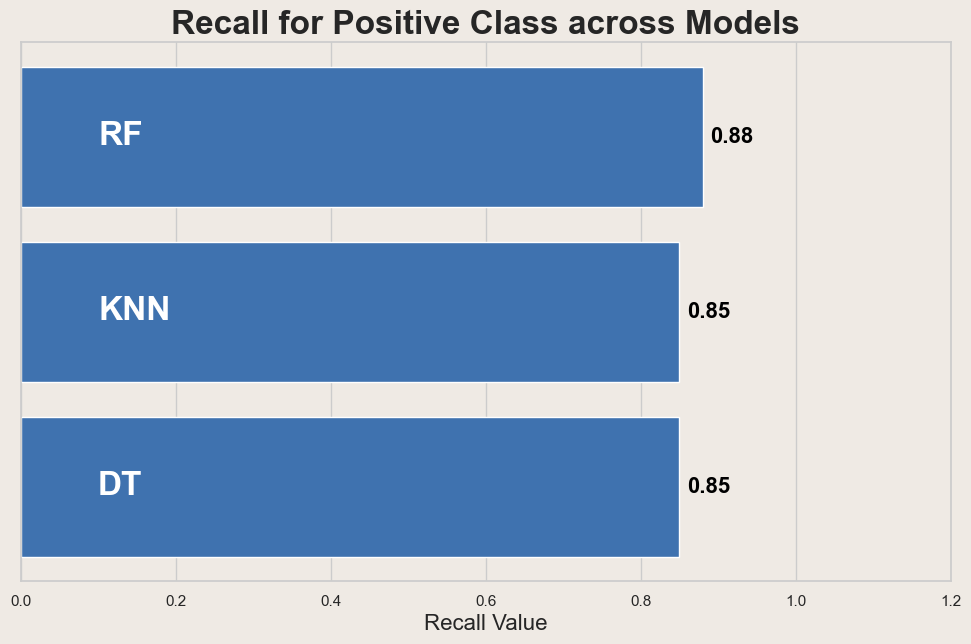

In [48]:
res.sort_values(by='recall_1',ascending=True,inplace=True)
recall_1_scores = res['recall_1']

fig, axes = plt.subplots(figsize=(12,7),dpi=100)
axes.barh(res.index,recall_1_scores,color='#3F72AF')

for i, (value,name) in enumerate(zip(recall_1_scores,res.index)):
	axes.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center',fontweight='bold',color='black',fontsize=16)
	axes.text(0.1, i, name, ha='left',va='center',fontweight='bold',color='white',fontsize=24)

axes.set_yticks([])

axes.set_xlim([0,1.2])

plt.title('Recall for Positive Class across Models',fontweight='bold',fontsize=24)
plt.xlabel('Recall Value',fontsize=16)
plt.show()